# Introduction

This notebook reproduces experiments reported in the paper "Leveraging Citizen Science and Low Cost Recorders for Acoustic Monitoring of Bird Species: A Case Study in Kenya" by Ciira wa Maina. The aim of the work is to investigate the use of acoustic models trained using data obtained from citizen scientists in automatic bird species recognition. We use data from the citizen science website [Xeno Canto](http://www.xeno-canto.org/) to train models for bird species recognition and test these models on data collected at the [Dedan Kimathi University of Technology](https://www.dkut.ac.ke/) [wildlife conservancy](https://conservancy.dkut.ac.ke/).

These audio data were collected using a low cost Raspberry Pi based recorder and are available on [Data Dryad]( http://dx.doi.org/10.5061/dryad.69g60). The recordings are described in the paper ["A Bioacoustic Record of a Conservancy in the Mount Kenya Ecosystem."](https://bdj.pensoft.net/articles.php?id=9906)

## Create Directory Structure

First create the directory structure

In [1]:
!chmod +x create_directory_structure.sh
!./create_directory_structure.sh

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘files’: File exists
mkdir: cannot create directory ‘figures’: File exists
mkdir: cannot create directory ‘data/dekuwc’: File exists
mkdir: cannot create directory ‘data/xeno_canto’: File exists
mkdir: cannot create directory ‘data/xeno_canto/mp3’: File exists
mkdir: cannot create directory ‘data/xeno_canto/wav-16kHz’: File exists
mkdir: cannot create directory ‘data/dekuwc/wav-16kHz’: File exists
mkdir: cannot create directory ‘figures/HATU_Spectrograms/’: File exists


## Download Data

We first download the 2701 recordings in mp3 format and a text file describing the data. All the data will be stored in the 'data' directory (770 MB).

In [2]:
import urllib.request
import os
import zipfile

files_downloaded=os.listdir('data/dekuwc')
data_readme_url='http://datadryad.org/bitstream/handle/10255/dryad.125720/README.txt?sequence=1'
if 'README' not in files_downloaded:
    urllib.request.urlretrieve(data_readme_url,'data/dekuwc/README')
data_url='http://datadryad.org/bitstream/handle/10255/dryad.125720/DeKUWC-Recordings-DataPackage-2016.zip?sequence=2'
if 'DeKUWC_Recordings_DataPackage_2016.zip' not in files_downloaded:
    urllib.request.urlretrieve(data_url,'data/dekuwc/DeKUWC_Recordings_DataPackage_2016.zip')

#unzip
if 'DeKUWC-Recordings-DataPackage-2016' not in files_downloaded:
    datafile=zipfile.ZipFile('data/dekuwc/DeKUWC-Recordings-DataPackage-2016.zip', 'r')
    datafile.extractall('data/dekuwc')
    datafile.close()
    

Convert mp3 to wav. 

In [3]:
mp3_dir = 'data/dekuwc/DeKUWC-Recordings-DataPackage-2016/mp3/'
wav_dir = 'data/dekuwc/wav-16kHz/'
mp3s=os.listdir(mp3_dir)
wavs=os.listdir(wav_dir)

for filename in mp3s:
    if filename.split('.')[0]+'.wav' not in wavs:
        print('Converting...',filename)
        cmd ='sox '+mp3_dir+filename+' -r 16000 -c 1 '+wav_dir+filename.split('.')[0]+'.wav'
        os.system(cmd)
    

## Data processing
Let's get information on bird species present in the audio recordings. 

In [4]:
#all necessary imports
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy as sp
from scipy import signal
import scipy.io.wavfile
import librosa
import librosa.display
import pandas as pd
import os
import json
import requests
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import pairwise_distances,accuracy_score,precision_score,recall_score, f1_score,hamming_loss,classification_report
from sklearn.model_selection import KFold,train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve,auc
from tabulate import tabulate
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
import csv
import time

np.random.seed(123)#for reproducibility
t1=time.time()

#Download information on all species observed at DeKUWC (both point counts and acoustically). These has information on codes
allspecies_table_url='http://bdj.pensoft.net//lib/ajax_srv/article_elements_srv.php?action=download_table_csv&instance_id=3276052&article_id=9906'
allspecies_file_name='files/all_species.csv'
urllib.request.urlretrieve(allspecies_table_url,allspecies_file_name)

#Download list of species in foreground and background of recordings ( data in the paper)
foreground_table_url='http://bdj.pensoft.net//lib/ajax_srv/article_elements_srv.php?action=download_table_csv&instance_id=3276675&article_id=9906'
foreground_file_name='files/foreground.csv'
background_table_url='http://bdj.pensoft.net//lib/ajax_srv/article_elements_srv.php?action=download_table_csv&instance_id=3276676&article_id=9906'
background_file_name='files/background.csv'
urllib.request.urlretrieve(foreground_table_url,foreground_file_name);
urllib.request.urlretrieve(background_table_url,background_file_name);

Using the list of foreground and background recordings, we will get a list of the 36 species identified in the annotated recordings. We also change the entry for the Common Bulbul (*Pycnonotus barbatus*) to Dark-capped Bulbul (*Pycnonotus tricolor*) to correspond to the IOC taxonomy used in Xeno-canto.

In [5]:
df_allspecies=pd.read_csv('files/all_species.csv',sep=';')
df_allspecies
df_foreground=pd.read_csv('files/foreground.csv',sep=';')
df_background=pd.read_csv('files/background.csv',sep=';')
species= set(df_foreground['Scientific Name'])#.union(set(df_background['Scientific Name']))
species=list(species)
species.sort()
species[species.index('Pycnonotus barbatus')]='Pycnonotus tricolor'
df_allspecies.loc[df_allspecies['Scientific Name']=='Pycnonotus barbatus','Four-Letter Code']
df_allspecies.loc[df_allspecies['Scientific Name']=='Pycnonotus barbatus','Four-Letter Code']='DCBU'
df_allspecies.loc[df_allspecies['Scientific Name']=='Pycnonotus barbatus','Common Name']='Dark-capped Bulbul'
df_allspecies.loc[df_allspecies['Scientific Name']=='Pycnonotus barbatus','Scientific Name']='Pycnonotus tricolor'
all_species_sp=list(df_allspecies['Scientific Name'])
all_species_cn=list(df_allspecies['Common Name'])
all_species_code=list(df_allspecies['Four-Letter Code'])

We will learn models for species appearing in the foreground of more than 10 recordings in the annotated recodings.

For each of the species, we will download all recordings of the species from Xeno-canto regardless quality and use them to train models. Each time this is run it may download recent uploads.

In [6]:
fg_species=list(df_foreground[df_foreground['Number of Recordings']>=10]['Scientific Name'])

In [7]:
data_dir='data/xeno_canto/mp3/'
#get recordings already present
XC_file=os.listdir(data_dir)

#download
recording_data=[]
number_recordings=[]
for sp in fg_species:
    webaddress='http://www.xeno-canto.org/api/2/recordings?query='+sp.split()[0]+'+'+sp.split()[1]+'+cnt:kenya'
    response=requests.get(webaddress)
    num_rec=0
    if response.status_code==200:
        data=response.json()
        rec=data['recordings']
        print ('Successful Query',all_species_cn[all_species_sp.index(sp)],int(data['numRecordings']))
        if len(rec)>0:
            for j in range(len(rec)):
                if rec[j]['rec']!='Ciira Maina' and rec[j]['q']!='no score':#Ignore recordings by author to avoid possible 'known individuals' and recordings with no score
                    #print(sp,rec[j]['id'],rec[j]['rec'],rec[j]['url'])
                    num_rec+=1
            for j in range(len(rec)):
                if rec[j]['rec']!='Ciira Maina' and rec[j]['q']!='no score':#Ignore recordings by author to avoid possible 'known individuals' and recordings with no score
                    #print(sp,rec[j]['id'],rec[j]['rec'],rec[j]['url'])
                    if XC_file.count(str(rec[j]['id'])+'.mp3')==0:#recording is not present
                        print ('Downloading file ',rec[j]['id'],'for',sp)
                        filename=data_dir+rec[j]['id']+'.mp3'
                        urllib.request.urlretrieve('https:'+rec[j]['file'],filename)
                    recording_data.append([rec[j]['id'],rec[j]['en'],sp,rec[j]['rec'],rec[j]['url']])

        number_recordings.append(num_rec)                    
                   
df_xc=pd.DataFrame.from_records(recording_data,columns=['Xeno-canto ID','Common Name','Scientific Name','Recordist','url'])
recog_species=list(set(df_xc['Scientific Name']))
recog_species.sort()
recog_species_cn=[all_species_cn[all_species_sp.index(recog_species[i])] for i in range(len(recog_species))]
recog_species_code=[all_species_code[all_species_sp.index(recog_species[i])] for i in range(len(recog_species))]
recog_species_numrec=[number_recordings[fg_species.index(recog_species[i])] for i in range(len(recog_species))]

#save
rows = zip(recog_species,recog_species_cn,recog_species_code,recog_species_numrec)
with open("files/recog_species.csv", "w") as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)


df_xc.to_csv('files/recordings.csv',index=False)

Successful Query Yellow-whiskered Greenbul 23
Successful Query Grey-backed Camaroptera 43
Successful Query Hartlaub's Turaco 14
Successful Query Yellow-rumped Tinkerbird 19
Successful Query Tambourine Dove 3
Successful Query Tropical Boubou 33
Successful Query Black-backed Puffback 20


We convert the mp3 files to wav.

In [8]:
mp3_dir = 'data/xeno_canto/mp3/'
wav_dir = 'data/xeno_canto/wav-16kHz/'
mp3s=os.listdir(mp3_dir)
wavs=os.listdir('data/xeno_canto/wav-16kHz/')

for filename in mp3s:
    if filename.split('.')[0]+'.wav' not in wavs:
        print('Converting...',filename)
        cmd ='sox '+mp3_dir+filename+' -r 16000 -c 1 '+wav_dir+filename.split('.')[0]+'.wav'
        os.system(cmd)



## Preliminary visualisations
Now we can examine some of the audio data and plot some spectrograms. Figure 3a in the paper.

The recording is XC59937 from Xeno-canto.


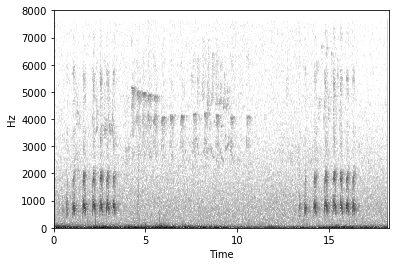

In [9]:
#audio parameters
Nfft=512
Noverlap=256
f_min=300
f_max=8000
num_mel=80
summary='mean_std'

#indx=np.random.randint(0,len(df_xc)-1)df_xc['Common Name']
CatNo=59937 #Xeno canto catalogue number
print('The recording is XC%d from Xeno-canto.'%CatNo)

x = scipy.io.wavfile.read(wav_dir+str(CatNo)+'.wav')
fs = float(x[0])
x2 = x[1] / 2.**15
x2 = x2 / np.max(np.abs(x2))
Spec = librosa.stft(x2,n_fft=Nfft, hop_length=Noverlap)
librosa.display.specshow(librosa.amplitude_to_db(Spec, ref=np.max),  cmap='gray_r',y_axis='linear', x_axis='time',sr=fs,hop_length=Noverlap);
plt.savefig('figures/XC_HT_spec.jpg',dpi=300)

The corresponding melspectrogram. Figure 3b in the paper

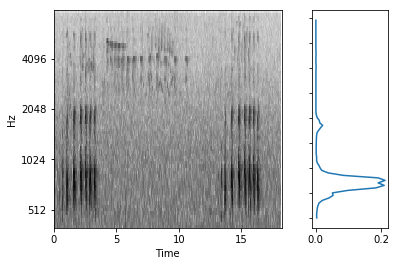

In [10]:
from matplotlib import gridspec
S = librosa.feature.melspectrogram(S=np.abs(Spec)**2, sr=fs, n_mels=num_mel,fmin=f_min,fmax=f_max)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), cmap='gray_r',y_axis='mel', x_axis='time',sr=fs,hop_length=Noverlap,fmin=f_min,fmax=f_max)

gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), cmap='gray_r',y_axis='mel', x_axis='time',sr=fs,hop_length=Noverlap,fmin=f_min,fmax=f_max)
ax1 = plt.subplot(gs[1])
ax1.plot(np.mean(S,1),np.arange(num_mel))
ax1.set_yticklabels('');
plt.savefig('figures/XC_HT_mel.jpg',dpi=300)

We now obtain features from the data for use in training and testing our classifiers. We will use the following features the melspectrogram summarised using the mean and standard deviation

## Melspectrogram Features

In [11]:
def avg_melspec(filename,Nfft,Noverlap,f_min,f_max,num_mel,summary):
    x = scipy.io.wavfile.read(filename)
    x2 = x[1] / 2.**15
    x2 = x2 / np.max(np.abs(x2))
    fs = float(x[0])
    Spec = librosa.stft(x2,n_fft=Nfft, hop_length=Noverlap)
    Spec=np.abs(Spec)
    S = librosa.feature.melspectrogram(S=np.abs(Spec)**2, sr=fs, n_mels=num_mel,fmin=f_min,fmax=f_max)
    S/=S.max()
    meanS=np.mean(S,1)
    
    if summary=='mean':
        return meanS
    elif summary=='mean_std':
        return np.concatenate((meanS,np.std(S,1)))
    elif summary=='max':
        return np.max(S,1)
        
features=[]
labels=[]


for i in range(len(df_xc)):
    print('Processing XC%d'%int(df_xc['Xeno-canto ID'][i]))
    features.append(avg_melspec(wav_dir+df_xc['Xeno-canto ID'][i]+'.wav',Nfft,Noverlap,f_min,f_max,num_mel,summary))
    labels.append(recog_species.index(df_xc['Scientific Name'][i]))


X=np.array(features)
labels=np.array(labels)
y=label_binarize(labels,np.unique(labels))

Processing XC399131
Processing XC318287
Processing XC205780
Processing XC201221
Processing XC396379
Processing XC365413
Processing XC344996
Processing XC293991
Processing XC163357
Processing XC122417
Processing XC120611
Processing XC101230
Processing XC101229
Processing XC93688
Processing XC93687
Processing XC73418
Processing XC18465
Processing XC374341
Processing XC131906
Processing XC371862
Processing XC373666
Processing XC366274
Processing XC366269
Processing XC293907
Processing XC98727
Processing XC98718
Processing XC396429
Processing XC366275
Processing XC366273
Processing XC366271
Processing XC366270
Processing XC366268
Processing XC366267
Processing XC364274
Processing XC317504
Processing XC294993
Processing XC290026
Processing XC240628
Processing XC235194
Processing XC205679
Processing XC205678
Processing XC201218
Processing XC120617
Processing XC101177
Processing XC101176
Processing XC101175
Processing XC90888
Processing XC73422
Processing XC62963
Processing XC62923
Processing

We now test the performance of a random forest classifier by determining the precision, recall and F1 score for each species using 20 random splits of the data into 70% for training and 30% for testing.



In [12]:
NT=500 #number of trees
num_trial=20
test_proportion=.3
species_precision=np.zeros((len(recog_species),num_trial))
species_recall=np.zeros((len(recog_species),num_trial))
species_f1=np.zeros((len(recog_species),num_trial))
trial_pred_scores=[]
trial_y_test=[]
for trial in range(num_trial):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_proportion)
    print('Training random forest classifier...')
    clf= OneVsRestClassifier(RandomForestClassifier(n_estimators=NT,criterion='entropy'))
    clf.fit(X_train,y_train)
    result=clf.predict(X_test)
    scores=clf.predict_proba(X_test)
    top_res=np.zeros(result.shape)
    top_3_res=np.zeros(result.shape)
    trial_pred_scores.append(scores)
    trial_y_test.append(y_test)

    print('Screening...')
    for i in range(result.shape[0]):
        line=''
        for j in range(len(y_test[i,:].nonzero()[0])):
            line+=recog_species_code[y_test[i,:].nonzero()[0][j]]+' '
        line+=';'

        indx=np.argsort(scores[i,:])[::-1][0:3].tolist()
        top_res[i,indx[0]]=1
        top_3_res[i,indx]=1
        file_species=[recog_species_code[i] for i in indx]
        for j in range(len(file_species)):
            line+=file_species[j]+' '

        print(line)
    for i in range(len(recog_species)):
        species_precision[i,trial]=precision_score(y_test[:,i],top_res[:,i])
        species_recall[i,trial]=recall_score(y_test[:,i],top_res[:,i])
        species_f1[i,trial]=f1_score(y_test[:,i],top_res[:,i])
         
print(classification_report(y_test, top_res, target_names=recog_species_cn))


Training random forest classifier...
Screening...
GBCA ;GBCA BBPU YWGR 
GBCA ;GBCA YWGR BBPU 
TRBO ;TRBO YRTI YWGR 
TRBO ;TRBO YRTI BBPU 
GBCA ;YWGR GBCA BBPU 
BBPU ;GBCA BBPU YWGR 
GBCA ;GBCA TRBO BBPU 
GBCA ;GBCA BBPU TRBO 
HATU ;HATU TRBO YRTI 
BBPU ;YWGR TRBO BBPU 
TRBO ;TRBO YRTI YWGR 
YWGR ;YRTI YWGR GBCA 
BBPU ;GBCA BBPU YWGR 
GBCA ;GBCA BBPU YWGR 
HATU ;HATU TRBO YRTI 
GBCA ;GBCA BBPU YWGR 
YWGR ;YWGR YRTI TRBO 
GBCA ;GBCA BBPU TRBO 
YRTI ;YRTI TADO HATU 
TRBO ;TRBO YRTI BBPU 
BBPU ;YWGR BBPU TRBO 
HATU ;HATU TADO TRBO 
YRTI ;YRTI TRBO TADO 
YWGR ;GBCA YWGR BBPU 
YWGR ;TRBO BBPU GBCA 
YWGR ;GBCA TRBO YWGR 
YWGR ;YWGR GBCA BBPU 
YRTI ;YRTI TRBO BBPU 
BBPU ;GBCA BBPU TRBO 
GBCA ;GBCA BBPU YWGR 
GBCA ;GBCA YWGR BBPU 
HATU ;TRBO YWGR BBPU 
YRTI ;TRBO YRTI HATU 
BBPU ;YWGR BBPU GBCA 
BBPU ;BBPU YWGR TRBO 
TRBO ;GBCA TRBO YWGR 
GBCA ;GBCA YRTI BBPU 
YWGR ;YWGR BBPU GBCA 
GBCA ;GBCA TRBO YWGR 
BBPU ;GBCA BBPU TRBO 
GBCA ;YWGR GBCA BBPU 
YWGR ;YWGR BBPU GBCA 
YRTI ;GBCA TRBO BBPU 
TRBO

/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Screening...
YRTI ;TRBO YRTI HATU 
TRBO ;GBCA YRTI HATU 
HATU ;TADO YRTI TRBO 
GBCA ;GBCA BBPU HATU 
TRBO ;TRBO GBCA HATU 
TRBO ;TRBO HATU YWGR 
BBPU ;GBCA BBPU YRTI 
GBCA ;GBCA BBPU YRTI 
TRBO ;TRBO YRTI BBPU 
GBCA ;GBCA TRBO BBPU 
YRTI ;YRTI TRBO YWGR 
GBCA ;GBCA BBPU YWGR 
TRBO ;TRBO YRTI BBPU 
TRBO ;TRBO YRTI BBPU 
GBCA ;GBCA YWGR BBPU 
TRBO ;BBPU GBCA HATU 
TRBO ;GBCA BBPU YWGR 
GBCA ;GBCA BBPU TADO 
YRTI ;TRBO YRTI GBCA 
GBCA ;GBCA YRTI YWGR 
HATU ;HATU TRBO YRTI 
GBCA ;GBCA BBPU YWGR 
HATU ;HATU TRBO YRTI 
BBPU ;GBCA YWGR BBPU 
HATU ;HATU GBCA TRBO 
TADO ;YRTI TADO TRBO 
YWGR ;YWGR BBPU GBCA 
TRBO ;GBCA YRTI YWGR 
TRBO ;TRBO YRTI HATU 
BBPU ;BBPU YWGR TRBO 
YRTI ;YRTI TRBO TADO 
HATU ;TRBO HATU YRTI 
TRBO ;TRBO BBPU YRTI 
YWGR ;YWGR BBPU TRBO 
GBCA ;GBCA YWGR HATU 
GBCA ;BBPU GBCA YWGR 
GBCA ;GBCA BBPU HATU 
TRBO ;TRBO HATU YWGR 
YWGR ;GBCA YRTI TADO 
TRBO ;TRBO YRTI HATU 
YRTI ;YRTI YWGR TRBO 
TRBO ;TRBO YRTI GBCA 
TRBO ;TRBO YRTI YWGR 
YRTI ;YRTI TRBO YWGR 
Training random for

/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Screening...
YRTI ;YRTI TRBO TADO 
GBCA ;GBCA BBPU YWGR 
BBPU ;GBCA BBPU HATU 
TRBO ;TRBO HATU YWGR 
GBCA ;GBCA BBPU TRBO 
TRBO ;TRBO YRTI BBPU 
GBCA ;GBCA BBPU YWGR 
GBCA ;BBPU GBCA HATU 
YRTI ;TRBO YRTI HATU 
TRBO ;TRBO YRTI HATU 
TRBO ;TRBO YRTI HATU 
GBCA ;GBCA YWGR TRBO 
YRTI ;YRTI YWGR TRBO 
TRBO ;TRBO YRTI YWGR 
YWGR ;YWGR BBPU GBCA 
BBPU ;GBCA BBPU YWGR 
GBCA ;GBCA BBPU YWGR 
YWGR ;YWGR TRBO BBPU 
GBCA ;GBCA HATU BBPU 
YWGR ;GBCA BBPU YWGR 
BBPU ;BBPU TRBO YWGR 
TRBO ;TRBO YRTI BBPU 
GBCA ;GBCA YWGR BBPU 
BBPU ;GBCA TRBO BBPU 
GBCA ;GBCA YWGR BBPU 
YRTI ;YRTI TRBO YWGR 
TRBO ;TRBO GBCA HATU 
TADO ;GBCA YWGR HATU 
GBCA ;TRBO YRTI GBCA 
GBCA ;GBCA BBPU YWGR 
TRBO ;YRTI BBPU TRBO 
TRBO ;TRBO BBPU YRTI 
TRBO ;HATU TRBO BBPU 
GBCA ;GBCA BBPU YRTI 
YWGR ;GBCA YWGR BBPU 
BBPU ;GBCA BBPU YWGR 
YRTI ;HATU YWGR TRBO 
GBCA ;GBCA TRBO BBPU 
TRBO ;TRBO YRTI YWGR 
YWGR ;BBPU YWGR GBCA 
HATU ;HATU TRBO YRTI 
HATU ;HATU TRBO BBPU 
YWGR ;YWGR GBCA BBPU 
TRBO ;TRBO HATU GBCA 
Training random for

/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6 is present in all training examples.
  str(classes[c]))


Screening...
TRBO ;TRBO YRTI YWGR 
YRTI ;YRTI TRBO YWGR 
TADO ;TRBO YRTI HATU 
TADO ;YWGR TRBO HATU 
YRTI ;TRBO HATU YRTI 
GBCA ;YWGR YRTI TRBO 
GBCA ;GBCA BBPU YWGR 
YWGR ;BBPU GBCA YWGR 
GBCA ;GBCA BBPU YWGR 
GBCA ;GBCA YWGR BBPU 
BBPU ;GBCA TRBO BBPU 
GBCA ;BBPU GBCA YWGR 
YWGR ;YWGR GBCA BBPU 
GBCA ;GBCA BBPU TRBO 
GBCA ;GBCA HATU BBPU 
GBCA ;GBCA BBPU YWGR 
TRBO ;TRBO GBCA HATU 
BBPU ;GBCA BBPU YRTI 
TRBO ;GBCA BBPU HATU 
TRBO ;GBCA BBPU HATU 
TRBO ;TRBO YRTI HATU 
YWGR ;GBCA BBPU YWGR 
TRBO ;TRBO YRTI YWGR 
GBCA ;GBCA BBPU YWGR 
YRTI ;YRTI TRBO HATU 
GBCA ;GBCA BBPU YWGR 
YWGR ;GBCA BBPU YWGR 
GBCA ;GBCA HATU TRBO 
TRBO ;TRBO YRTI YWGR 
YWGR ;YWGR TRBO YRTI 
YWGR ;YWGR BBPU TRBO 
YWGR ;YWGR GBCA BBPU 
TADO ;HATU YRTI TRBO 
BBPU ;TRBO YRTI YWGR 
TRBO ;TRBO HATU YWGR 
TRBO ;TRBO GBCA YRTI 
YWGR ;YWGR TRBO BBPU 
BBPU ;BBPU TRBO YWGR 
YRTI ;TRBO YRTI YWGR 
HATU ;HATU TRBO YWGR 
YWGR ;YWGR GBCA BBPU 
YWGR ;GBCA BBPU YWGR 
GBCA ;GBCA BBPU YWGR 
TRBO ;YRTI TRBO GBCA 
Training random for

/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6 is present in all training examples.
  str(classes[c]))


Screening...
YWGR ;YWGR BBPU GBCA 
HATU ;HATU YWGR TRBO 
GBCA ;YWGR GBCA BBPU 
GBCA ;GBCA BBPU TRBO 
YRTI ;YRTI TRBO YWGR 
TRBO ;TRBO YRTI HATU 
YRTI ;TRBO YRTI HATU 
BBPU ;YWGR TRBO GBCA 
GBCA ;GBCA BBPU TRBO 
YWGR ;YWGR GBCA BBPU 
BBPU ;YWGR GBCA TRBO 
YRTI ;TRBO YRTI YWGR 
GBCA ;TRBO YWGR YRTI 
TRBO ;GBCA TRBO HATU 
YWGR ;GBCA BBPU YWGR 
GBCA ;GBCA YWGR BBPU 
TRBO ;TRBO HATU YWGR 
BBPU ;BBPU YWGR TRBO 
TRBO ;TRBO YRTI HATU 
GBCA ;GBCA YWGR TRBO 
GBCA ;GBCA YWGR BBPU 
TADO ;YWGR GBCA HATU 
BBPU ;GBCA TRBO BBPU 
HATU ;TRBO YWGR GBCA 
YWGR ;YWGR GBCA BBPU 
TRBO ;GBCA HATU TRBO 
TRBO ;YRTI TRBO HATU 
GBCA ;GBCA BBPU YWGR 
TADO ;HATU YRTI GBCA 
GBCA ;GBCA YWGR TRBO 
YRTI ;YRTI TRBO YWGR 
TADO ;YRTI HATU TRBO 
GBCA ;GBCA YWGR TRBO 
BBPU ;TRBO YRTI YWGR 
BBPU ;BBPU GBCA YWGR 
GBCA ;GBCA BBPU YWGR 
TRBO ;TRBO YRTI HATU 
GBCA ;BBPU GBCA YWGR 
TRBO ;TRBO YWGR HATU 
TRBO ;YWGR HATU TRBO 
YWGR ;YWGR BBPU TRBO 
GBCA ;GBCA BBPU YWGR 
TRBO ;TRBO YRTI YWGR 
GBCA ;GBCA BBPU TRBO 
Training random for

/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Screening...
GBCA ;GBCA YWGR TRBO 
TRBO ;TRBO YWGR HATU 
HATU ;TRBO YWGR HATU 
GBCA ;GBCA BBPU YWGR 
GBCA ;GBCA BBPU YWGR 
BBPU ;YWGR TRBO BBPU 
HATU ;TRBO HATU YWGR 
HATU ;TRBO HATU YRTI 
TRBO ;TRBO HATU TADO 
YRTI ;TRBO YRTI HATU 
GBCA ;GBCA BBPU TRBO 
YRTI ;YRTI TRBO BBPU 
YWGR ;YWGR TRBO BBPU 
TRBO ;TRBO YWGR YRTI 
YRTI ;TRBO YRTI YWGR 
YRTI ;YRTI TRBO TADO 
GBCA ;GBCA YWGR BBPU 
GBCA ;GBCA TRBO HATU 
YRTI ;YWGR TRBO HATU 
BBPU ;GBCA YWGR BBPU 
HATU ;HATU TRBO BBPU 
BBPU ;YWGR BBPU TRBO 
TRBO ;TRBO YRTI HATU 
TRBO ;TRBO YRTI HATU 
BBPU ;BBPU TRBO YWGR 
TRBO ;TRBO YWGR GBCA 
YRTI ;YRTI TADO HATU 
YRTI ;YRTI TRBO YWGR 
YWGR ;YWGR TRBO BBPU 
GBCA ;GBCA YWGR BBPU 
HATU ;HATU TRBO TADO 
TRBO ;TRBO YRTI BBPU 
GBCA ;GBCA BBPU YWGR 
GBCA ;BBPU GBCA HATU 
GBCA ;YWGR GBCA TRBO 
TADO ;YWGR TRBO GBCA 
YRTI ;TRBO BBPU YRTI 
TRBO ;TRBO YWGR BBPU 
GBCA ;GBCA TRBO BBPU 
TRBO ;TRBO HATU GBCA 
YWGR ;GBCA BBPU YWGR 
HATU ;TRBO HATU YRTI 
HATU ;TRBO HATU YWGR 
TADO ;TADO TRBO YRTI 
Training random for

/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6 is present in all training examples.
  str(classes[c]))


Screening...
YRTI ;YRTI TRBO YWGR 
BBPU ;TRBO YRTI HATU 
TRBO ;TRBO YRTI BBPU 
GBCA ;GBCA YWGR BBPU 
GBCA ;GBCA YWGR BBPU 
TRBO ;YRTI TRBO YWGR 
GBCA ;GBCA YRTI YWGR 
TRBO ;YRTI TRBO GBCA 
GBCA ;GBCA BBPU YWGR 
GBCA ;GBCA BBPU HATU 
GBCA ;BBPU GBCA YWGR 
TRBO ;TRBO YRTI HATU 
YWGR ;YWGR TRBO BBPU 
HATU ;HATU TRBO YRTI 
YRTI ;TRBO YRTI YWGR 
GBCA ;GBCA BBPU TRBO 
HATU ;HATU TRBO YRTI 
HATU ;HATU TRBO YWGR 
TRBO ;GBCA YRTI HATU 
TRBO ;TRBO YRTI GBCA 
GBCA ;GBCA BBPU YWGR 
GBCA ;YWGR GBCA BBPU 
GBCA ;GBCA YWGR BBPU 
TADO ;HATU YRTI TRBO 
GBCA ;GBCA YWGR TRBO 
TRBO ;GBCA BBPU YWGR 
YWGR ;GBCA YWGR BBPU 
YRTI ;TRBO YRTI YWGR 
GBCA ;GBCA YRTI TRBO 
BBPU ;GBCA BBPU HATU 
TRBO ;HATU YWGR TRBO 
TRBO ;TRBO YRTI HATU 
BBPU ;TRBO YWGR BBPU 
YRTI ;TRBO YRTI YWGR 
YRTI ;YRTI TRBO YWGR 
GBCA ;YWGR GBCA BBPU 
BBPU ;YWGR BBPU GBCA 
BBPU ;GBCA BBPU YWGR 
GBCA ;GBCA BBPU YWGR 
TADO ;GBCA YWGR HATU 
TADO ;YRTI HATU TRBO 
TRBO ;TRBO YRTI GBCA 
GBCA ;GBCA YWGR BBPU 
TRBO ;TRBO YRTI HATU 
Training random for

/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Screening...
YWGR ;YWGR BBPU YRTI 
BBPU ;GBCA TRBO BBPU 
HATU ;HATU TADO TRBO 
YRTI ;TRBO YRTI TADO 
TRBO ;TRBO YRTI YWGR 
BBPU ;YWGR BBPU GBCA 
GBCA ;GBCA BBPU YWGR 
TRBO ;TRBO YRTI HATU 
GBCA ;GBCA YWGR BBPU 
YRTI ;YRTI TRBO YWGR 
BBPU ;YWGR BBPU TRBO 
GBCA ;GBCA YWGR BBPU 
BBPU ;GBCA BBPU TRBO 
YRTI ;YRTI TRBO HATU 
HATU ;YWGR BBPU GBCA 
TRBO ;TRBO HATU GBCA 
TRBO ;TRBO YRTI BBPU 
BBPU ;GBCA BBPU TRBO 
GBCA ;GBCA YWGR BBPU 
BBPU ;GBCA YRTI TRBO 
HATU ;HATU TRBO YRTI 
BBPU ;YWGR BBPU TRBO 
YWGR ;GBCA YRTI TADO 
GBCA ;YWGR TADO TRBO 
TRBO ;YWGR YRTI TRBO 
TRBO ;YWGR HATU BBPU 
GBCA ;GBCA BBPU HATU 
TRBO ;TRBO HATU YWGR 
YWGR ;YWGR GBCA BBPU 
TRBO ;TRBO YRTI YWGR 
TRBO ;YWGR TRBO HATU 
BBPU ;GBCA BBPU YWGR 
YRTI ;YRTI TRBO HATU 
GBCA ;GBCA YRTI TRBO 
GBCA ;GBCA YWGR BBPU 
TRBO ;TRBO YRTI HATU 
GBCA ;GBCA TRBO YWGR 
GBCA ;GBCA YWGR BBPU 
HATU ;HATU TRBO TADO 
GBCA ;GBCA YWGR TRBO 
TRBO ;TRBO YRTI BBPU 
TRBO ;TRBO YRTI YWGR 
HATU ;HATU TRBO YRTI 
GBCA ;GBCA BBPU YWGR 
Training random for

/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Screening...
GBCA ;GBCA YWGR BBPU 
TRBO ;GBCA TRBO HATU 
TRBO ;TRBO YRTI GBCA 
GBCA ;GBCA YWGR BBPU 
TRBO ;HATU TRBO YWGR 
HATU ;HATU YWGR TRBO 
TRBO ;HATU YWGR BBPU 
GBCA ;GBCA BBPU YWGR 
TRBO ;HATU TRBO YWGR 
BBPU ;GBCA BBPU YWGR 
GBCA ;GBCA HATU BBPU 
HATU ;HATU TADO TRBO 
YRTI ;TRBO YRTI GBCA 
YRTI ;YRTI TRBO YWGR 
YRTI ;YRTI TRBO GBCA 
TRBO ;GBCA BBPU TRBO 
GBCA ;GBCA BBPU YWGR 
YRTI ;YRTI TADO TRBO 
YRTI ;YRTI TRBO TADO 
YWGR ;YWGR BBPU YRTI 
TADO ;YRTI TADO TRBO 
TRBO ;TRBO YRTI HATU 
YRTI ;YRTI TRBO YWGR 
TRBO ;HATU YRTI TRBO 
TRBO ;TRBO YRTI HATU 
GBCA ;GBCA BBPU YWGR 
GBCA ;GBCA BBPU YWGR 
GBCA ;GBCA BBPU YWGR 
YRTI ;YRTI TRBO YWGR 
TRBO ;TRBO YRTI HATU 
TRBO ;HATU YWGR YRTI 
BBPU ;BBPU GBCA TRBO 
HATU ;HATU GBCA TRBO 
TRBO ;TRBO GBCA YRTI 
TRBO ;TRBO YRTI HATU 
TRBO ;GBCA TRBO YWGR 
YRTI ;HATU YWGR GBCA 
TRBO ;YRTI TRBO YWGR 
TRBO ;GBCA HATU TRBO 
TRBO ;HATU YWGR TRBO 
YRTI ;GBCA YRTI HATU 
HATU ;HATU TADO TRBO 
TRBO ;GBCA HATU TRBO 
TRBO ;TRBO HATU YRTI 
Training random for

/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Screening...
YWGR ;GBCA YRTI TADO 
YWGR ;YWGR YRTI GBCA 
BBPU ;BBPU YWGR TRBO 
TRBO ;TRBO YRTI HATU 
BBPU ;GBCA TRBO BBPU 
YRTI ;YRTI TRBO BBPU 
TRBO ;TRBO YRTI GBCA 
GBCA ;GBCA YRTI BBPU 
BBPU ;GBCA BBPU HATU 
BBPU ;BBPU GBCA YWGR 
TRBO ;HATU YWGR BBPU 
GBCA ;GBCA YRTI TRBO 
HATU ;HATU TRBO YRTI 
GBCA ;GBCA BBPU HATU 
HATU ;HATU TRBO YWGR 
TRBO ;TRBO YRTI YWGR 
GBCA ;GBCA YWGR BBPU 
GBCA ;GBCA BBPU YWGR 
HATU ;HATU YRTI TRBO 
GBCA ;GBCA TRBO HATU 
YWGR ;YWGR BBPU TRBO 
TRBO ;GBCA TRBO YWGR 
GBCA ;GBCA BBPU YWGR 
GBCA ;GBCA TRBO YWGR 
TRBO ;YRTI HATU TRBO 
BBPU ;GBCA YWGR BBPU 
YRTI ;TRBO YRTI YWGR 
YWGR ;GBCA YWGR BBPU 
TRBO ;TRBO YRTI GBCA 
YWGR ;GBCA YWGR BBPU 
HATU ;HATU TRBO YRTI 
GBCA ;GBCA TADO BBPU 
TRBO ;TRBO GBCA HATU 
YRTI ;YRTI TRBO YWGR 
TRBO ;YRTI TRBO HATU 
BBPU ;BBPU GBCA TRBO 
TRBO ;TRBO YWGR BBPU 
YWGR ;YWGR GBCA BBPU 
BBPU ;YWGR BBPU GBCA 
GBCA ;GBCA BBPU TRBO 
YRTI ;YRTI TRBO YWGR 
YRTI ;YRTI TRBO TADO 
TRBO ;TRBO YRTI HATU 
YWGR ;YWGR GBCA BBPU 
Training random for

/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Screening...
YWGR ;GBCA BBPU TRBO 
TRBO ;TRBO GBCA BBPU 
BBPU ;GBCA TRBO BBPU 
GBCA ;TRBO GBCA YWGR 
GBCA ;GBCA BBPU TRBO 
TRBO ;TRBO YRTI HATU 
HATU ;TRBO HATU GBCA 
TADO ;GBCA TRBO BBPU 
GBCA ;GBCA TRBO BBPU 
YWGR ;YWGR BBPU YRTI 
YRTI ;YRTI TRBO HATU 
TRBO ;TRBO GBCA HATU 
GBCA ;GBCA BBPU TRBO 
GBCA ;GBCA BBPU TRBO 
YRTI ;YRTI TRBO BBPU 
YWGR ;YWGR GBCA BBPU 
GBCA ;GBCA YWGR BBPU 
GBCA ;GBCA BBPU YWGR 
TRBO ;TRBO YRTI GBCA 
GBCA ;GBCA BBPU YWGR 
GBCA ;TRBO YWGR GBCA 
HATU ;GBCA TRBO BBPU 
TRBO ;YRTI TRBO BBPU 
YWGR ;YWGR BBPU TRBO 
GBCA ;GBCA BBPU TRBO 
HATU ;HATU TRBO YRTI 
GBCA ;GBCA BBPU YWGR 
YWGR ;GBCA BBPU YRTI 
YWGR ;GBCA YWGR BBPU 
GBCA ;GBCA BBPU YWGR 
YWGR ;BBPU YWGR GBCA 
GBCA ;GBCA TRBO YRTI 
YRTI ;YRTI TRBO BBPU 
YRTI ;GBCA YRTI TRBO 
HATU ;HATU GBCA TRBO 
YWGR ;YWGR BBPU YRTI 
TRBO ;TRBO YRTI YWGR 
YWGR ;GBCA TRBO YWGR 
GBCA ;GBCA BBPU TRBO 
YRTI ;TRBO YRTI GBCA 
GBCA ;GBCA TRBO HATU 
GBCA ;GBCA BBPU YWGR 
YRTI ;YRTI TRBO BBPU 
TRBO ;YRTI TRBO HATU 
Training random for

/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Screening...
TRBO ;TRBO YRTI HATU 
BBPU ;BBPU YWGR GBCA 
GBCA ;GBCA TRBO YRTI 
BBPU ;BBPU GBCA YWGR 
YWGR ;YWGR BBPU YRTI 
YWGR ;BBPU YWGR GBCA 
YWGR ;YWGR GBCA BBPU 
TRBO ;TRBO HATU BBPU 
TRBO ;TRBO BBPU YWGR 
TRBO ;TRBO YRTI HATU 
YWGR ;YWGR BBPU GBCA 
HATU ;HATU TRBO YRTI 
GBCA ;GBCA BBPU YWGR 
TRBO ;HATU YWGR BBPU 
GBCA ;GBCA BBPU TRBO 
YWGR ;YWGR BBPU GBCA 
BBPU ;BBPU YWGR TRBO 
GBCA ;YRTI YWGR TADO 
HATU ;HATU GBCA TRBO 
TRBO ;TRBO GBCA HATU 
GBCA ;BBPU GBCA YWGR 
GBCA ;GBCA YWGR TRBO 
YRTI ;YRTI TRBO BBPU 
YRTI ;TRBO YRTI BBPU 
GBCA ;GBCA YWGR BBPU 
GBCA ;GBCA TRBO YRTI 
YRTI ;YRTI TRBO YWGR 
TRBO ;TRBO YRTI BBPU 
GBCA ;GBCA YWGR BBPU 
BBPU ;GBCA TRBO BBPU 
GBCA ;GBCA YWGR BBPU 
YWGR ;YWGR GBCA BBPU 
TRBO ;TRBO HATU YRTI 
HATU ;HATU TRBO YRTI 
YWGR ;GBCA BBPU YWGR 
BBPU ;GBCA BBPU YWGR 
YRTI ;YRTI YWGR TRBO 
HATU ;GBCA BBPU TRBO 
GBCA ;BBPU GBCA YWGR 
GBCA ;GBCA TRBO BBPU 
BBPU ;GBCA YRTI BBPU 
GBCA ;GBCA BBPU YWGR 
GBCA ;GBCA BBPU TRBO 
TRBO ;TRBO YRTI GBCA 
Training random for

/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Screening...
YRTI ;TRBO YRTI TADO 
GBCA ;BBPU YWGR GBCA 
BBPU ;GBCA BBPU YWGR 
GBCA ;GBCA BBPU YWGR 
TRBO ;TRBO BBPU HATU 
TRBO ;TRBO YWGR YRTI 
GBCA ;GBCA TRBO BBPU 
GBCA ;GBCA BBPU YWGR 
YWGR ;YWGR GBCA TRBO 
HATU ;HATU TRBO YRTI 
HATU ;TRBO HATU YWGR 
GBCA ;YWGR GBCA BBPU 
HATU ;HATU TRBO TADO 
TRBO ;GBCA YWGR YRTI 
TRBO ;TRBO GBCA YRTI 
YRTI ;TRBO YRTI YWGR 
YWGR ;YWGR BBPU TRBO 
HATU ;HATU TRBO YRTI 
HATU ;HATU TRBO YRTI 
TRBO ;TRBO YRTI GBCA 
YWGR ;YWGR TRBO BBPU 
GBCA ;GBCA BBPU YWGR 
YWGR ;GBCA YWGR TRBO 
GBCA ;GBCA YWGR BBPU 
HATU ;TRBO HATU YRTI 
YRTI ;TRBO HATU YWGR 
TRBO ;TRBO YRTI HATU 
TRBO ;GBCA YRTI HATU 
TRBO ;TRBO YRTI HATU 
TRBO ;TRBO YWGR YRTI 
GBCA ;GBCA YWGR BBPU 
BBPU ;GBCA BBPU HATU 
BBPU ;YWGR BBPU YRTI 
YRTI ;YRTI TRBO TADO 
BBPU ;TRBO BBPU YWGR 
YRTI ;TRBO YRTI YWGR 
BBPU ;TRBO YRTI YWGR 
GBCA ;GBCA YWGR BBPU 
YRTI ;YRTI TRBO BBPU 
YRTI ;TRBO YRTI YWGR 
YWGR ;YWGR TRBO BBPU 
BBPU ;BBPU GBCA YWGR 
TRBO ;GBCA YWGR HATU 
YWGR ;YWGR TRBO BBPU 
                   

/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Produce box plots of the precision, recall and F1 score. Figure 4 in the paper.

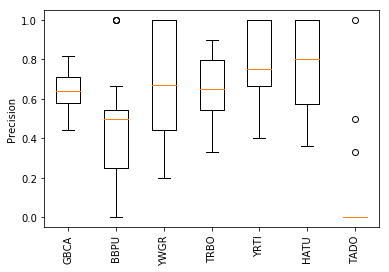

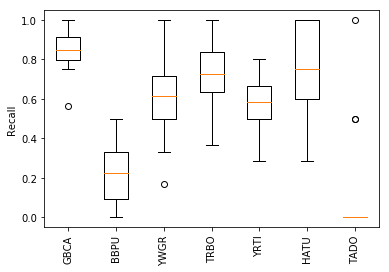

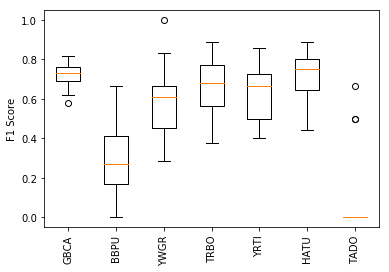

In [13]:
plt.figure()
plt.boxplot(species_precision.T)
plt.xticks(range(1,len(recog_species)+1), recog_species_code, rotation='vertical')
plt.ylabel('Precision')
plt.savefig('figures/xc_precision_mel.jpg',dpi=300)

plt.figure()
plt.boxplot(species_recall.T)
plt.xticks(range(1,len(recog_species)+1), recog_species_code, rotation='vertical')
plt.ylabel('Recall')
plt.savefig('figures/xc_recall_mel.jpg',dpi=300)

plt.figure()
plt.boxplot(species_f1.T)
plt.xticks(range(1,len(recog_species)+1), recog_species_code, rotation='vertical')
plt.ylabel('F1 Score')
plt.savefig('figures/xc_f1_mel.jpg',dpi=300)



Create a table with the median precision, recall and F1 score. Table 2 in the paper.

In [14]:
df_species_metrics=pd.DataFrame(list(zip(recog_species_code,np.median(species_precision,1).tolist(),np.median(species_recall,1).tolist(), np.median(species_f1,1).tolist())),columns=['Species','Precision','Recall','F1 Score'])
df_species_metrics=df_species_metrics.sort_values(['F1 Score'], ascending=False)
df_species_metrics=df_species_metrics.reset_index(drop=True)
print(df_species_metrics.round(2))

  Species  Precision  Recall  F1 Score
0    HATU       0.80    0.75      0.75
1    GBCA       0.64    0.85      0.73
2    TRBO       0.65    0.72      0.68
3    YRTI       0.75    0.59      0.67
4    YWGR       0.67    0.61      0.61
5    BBPU       0.50    0.22      0.27
6    TADO       0.00    0.00      0.00


### Screen DeKUWC recordings.

First we train with all the Xeno-canto data and use the data to determine species specific thresholds that maximize the F1 score for each species. This works better than applying a single threshold, say 0.5 for all species


In [15]:
#Train with all the xeno-canto data
clf_mel= OneVsRestClassifier(RandomForestClassifier(n_estimators=NT,criterion='entropy'))
clf_mel.fit(X,y)
xc_score=clf_mel.predict_proba(X)

species_threshold=np.zeros(len(recog_species_code))
thresh=np.linspace(0,1,100)

for sp_code in recog_species_code:
    f1_scores=np.zeros(len(thresh))
    for i in range(len(thresh)):
        f1_scores[i]=f1_score(y[:,recog_species_code.index(sp_code)],xc_score[:,recog_species_code.index(sp_code)]>thresh[i]);
    
    species_threshold[recog_species_code.index(sp_code)]=thresh[np.argmax(f1_scores)]
 

/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
df_dekuwc=pd.read_csv('PiRecordingsAnnotation.csv')
dekut_wavs=list(df_dekuwc['Filename'])
dekut_wavs.sort()
dekuwc_true_label=np.zeros((len(dekut_wavs),len(recog_species_code)))

dekuwc_pred_scores=[]
annotation=[]
recog_result=[]
for filename in dekut_wavs:
    print('Processing',filename)
    df=df_dekuwc.loc[df_dekuwc['Filename']==filename]
    
    features=avg_melspec('data/dekuwc/wav-16kHz/'+filename,Nfft,Noverlap,f_min,f_max,num_mel,summary)
    
    file_result=clf_mel.predict_proba(np.array(features).reshape(1, -1))
    dekuwc_pred_scores.append(file_result[0,:])
    indx=np.arange(len(recog_species_code))[file_result[0,:]>species_threshold]
    recog_file_species=[recog_species_code[i] for i in indx]
    true_file_species=df.iloc[0,1].split(';')
    if 'COBU' in true_file_species:
        true_file_species[true_file_species.index('COBU')]='DCBU'
    for i in range(len(true_file_species)):
        if true_file_species[i] in recog_species_code:
            dekuwc_true_label[dekut_wavs.index(filename),recog_species_code.index(true_file_species[i])]=1
    
    if len(recog_file_species)>0:
        dd=recog_file_species[0]
        for i in range(1,len(recog_file_species)):
            dd+=';'
            dd+=recog_file_species[i]
    else:
        dd=''
    annotation.append(df.iloc[0,1])
    recog_result.append(dd)
    #print(true_file_species+[';']+recog_file_species)
    
np.array(dekuwc_pred_scores)   
df_screening = pd.DataFrame(list(zip(dekut_wavs, annotation, recog_result)),columns=['Filenames','True Species','Recognition Result'])
df_screening.to_csv('files/screening_result_mel.csv',index=False)

Processing 1-2016-01-05-10-40-01.wav
Processing 1-2016-01-05-11-10-01.wav
Processing 1-2016-01-05-12-35-01.wav
Processing 1-2016-01-05-12-40-01.wav
Processing 1-2016-01-05-13-20-01.wav
Processing 1-2016-01-05-13-40-01.wav
Processing 1-2016-01-06-06-30-01.wav
Processing 1-2016-01-06-06-35-01.wav
Processing 1-2016-01-06-06-40-02.wav
Processing 1-2016-01-06-07-00-01.wav
Processing 1-2016-01-06-07-35-01.wav
Processing 1-2016-01-06-07-40-01.wav
Processing 1-2016-01-06-08-05-01.wav
Processing 1-2016-01-06-08-55-02.wav
Processing 1-2016-01-06-09-40-02.wav
Processing 1-2016-01-06-10-45-01.wav
Processing 1-2016-01-06-14-05-01.wav
Processing 1-2016-01-06-14-10-01.wav
Processing 2-2016-01-05-13-20-01.wav
Processing 2-2016-01-05-13-30-01.wav
Processing 2-2016-01-05-15-55-02.wav
Processing 2-2016-01-05-16-25-01.wav
Processing 2-2016-01-05-17-20-01.wav
Processing 2-2016-01-05-17-25-01.wav
Processing 2-2016-01-05-18-05-01.wav
Processing 2-2016-01-05-18-10-01.wav
Processing 2-2016-01-06-06-50-01.wav
P

In [17]:
recog_file_species
file_result>species_threshold
annotation

['YWGR',
 'TRBO',
 'GBCA',
 'GBCA',
 'COBU',
 'GBCA',
 'GBCA',
 'YWGR',
 'GBCA',
 'GBCA;BBPU;PICR',
 'BBPU;ABCR;BHOR',
 'GBCA',
 'COBU;YWGR;SCHO',
 'GBCA',
 'GBCA',
 'YRTI',
 'GBCA;YRTI',
 'YWGR;FTDR',
 'YWGR;GBCA',
 'YWGR',
 'GBCA',
 'YWGR',
 'YWGR',
 'YWGR',
 'YWGR;FTDR',
 'RURC;BWWA',
 'COBU;GBCA;TRBO',
 'YRTI;GBCA',
 'YWGR;GBCA',
 'TRBO;GBCA',
 'YWGR;YRTI',
 'YWGR;TRBO;GBCA',
 'GBCA;TADO',
 'YWGR;GBCA',
 'GBCA;YWGR',
 'YWGR',
 'YWGR;YRTI;BBPU',
 'BBPU',
 'HATU;YWGR',
 'YWGR;BBPU',
 'GBCA',
 'YWGR',
 'YWGR;VASU',
 'GBCA;APFL;YWGR',
 'YWGR',
 'YWGR',
 'COBU',
 'TADO;YWGR;HATU',
 'YWGR',
 'TRBO;YWGR',
 'HATU;COSU;YWGR',
 'YWGR',
 'YWGR;TADO;HATU',
 'TADO;YWGR;HATU',
 'YRTI;TADO',
 'YRTI;TADO',
 'TADO;YWGR;HATU',
 'YWGR',
 'YRTI;HATU;TADO;YWGR',
 'YWGR',
 'YWGR',
 'YRTI;TRBO',
 'YWGR;TADO',
 'YRTI;YWGR;GBCA',
 'HATU;YWGR;TADO',
 'TRBO',
 'YWGR;HATU',
 'YWGR;HATU',
 'YWGR',
 'TADO;YWGR;HATU',
 'YWGR;YRTI',
 'BBPU',
 'BBPU;HATU',
 'HATU;COBU',
 'OLSU;TADO;HATU;YRTI',
 'TADO;HATU;YWGR',
 

Show the screening result for a selection of five files. Table 4 of the paper (melspecrogram feature result)

In [18]:
print(df_screening.loc[df_screening['Filenames'].isin(['1-2016-01-05-10-40-01.wav','1-2016-01-05-11-10-01.wav','2-2016-01-06-07-45-01.wav','4-2016-01-06-11-45-01.wav','6-2016-01-29-12-35-01.wav'])].reset_index(drop=True))


                   Filenames    True Species Recognition Result
0  1-2016-01-05-10-40-01.wav            YWGR               GBCA
1  1-2016-01-05-11-10-01.wav            TRBO               TRBO
2  2-2016-01-06-07-45-01.wav       TRBO;GBCA               GBCA
3  4-2016-01-06-11-45-01.wav            HATU               HATU
4  6-2016-01-29-12-35-01.wav  YRTI;BBPU;TRBO               YRTI


Show the classification report. Table 3 of the paper. This is obtained using the threshold that optimizes the F1 score for each species and reports that species as present when its probability exceeds this threshold.

In [19]:
dekuwc_species_f1=np.zeros(len(recog_species_code))
dekuwc_species_precision=np.zeros(len(recog_species_code))
dekuwc_species_recall=np.zeros(len(recog_species_code))

dekuwc_pred_scores=np.vstack(dekuwc_pred_scores)
dekuwc_res=dekuwc_pred_scores>species_threshold

for sp_code in recog_species_code:
    dekuwc_species_f1[recog_species_code.index(sp_code)]=f1_score(dekuwc_true_label[:,recog_species_code.index(sp_code)],dekuwc_res[:,recog_species_code.index(sp_code)])
    dekuwc_species_precision[recog_species_code.index(sp_code)]=precision_score(dekuwc_true_label[:,recog_species_code.index(sp_code)],dekuwc_res[:,recog_species_code.index(sp_code)])
    dekuwc_species_recall[recog_species_code.index(sp_code)]=recall_score(dekuwc_true_label[:,recog_species_code.index(sp_code)],dekuwc_res[:,recog_species_code.index(sp_code)])
    
    
df_dekuwc_metrics=pd.DataFrame(list(zip(recog_species_code,dekuwc_species_precision.tolist(),dekuwc_species_recall.tolist(), dekuwc_species_f1.tolist())),columns=['Species','Precision','Recall','F1 Score'])
df_dekuwc_metrics=df_dekuwc_metrics.sort_values(['F1 Score'], ascending=False)
df_dekuwc_metrics=df_dekuwc_metrics.reset_index(drop=True)
print(df_dekuwc_metrics.round(2))

  Species  Precision  Recall  F1 Score
0    HATU       0.86    0.60      0.71
1    GBCA       0.67    0.58      0.62
2    YRTI       0.38    0.31      0.34
3    TRBO       0.32    0.35      0.33
4    YWGR       1.00    0.01      0.02
5    BBPU       0.00    0.00      0.00
6    TADO       0.00    0.00      0.00


/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ciira/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
print('Time taken for melspectrogram features is %.2f minutes'%((time.time()-t1)/60))

Time taken for melspectrogram features is 3.57 minutes


## Hartlaub's Turaco Screening

We now screen all the 2701 recordings obtained from the DeKUWC for presence of the Harltaub's Turaco. 


In [21]:
t1=time.time()
df_all_dekuwc=pd.read_csv('AllLocations_Annotation.csv')
all_filenames=list(df_all_dekuwc['Filename'])
all_dekuwc_pred_score=[]
for filename in all_filenames:
    print('Processing',filename)
    features=avg_melspec('data/dekuwc/wav-16kHz/'+filename+'.wav',Nfft,Noverlap,f_min,f_max,num_mel,summary)
    file_result=clf_mel.predict_proba(np.array(features).reshape(1, -1))
    all_dekuwc_pred_score.append(file_result[0,:])
    
print('Time taken to screen all files is %.2f minutes'%((time.time()-t1)/60))

Processing 1-2016-01-05-10-30-01
Processing 1-2016-01-05-10-35-02
Processing 1-2016-01-05-10-40-01
Processing 1-2016-01-05-10-45-01
Processing 1-2016-01-05-10-50-01
Processing 1-2016-01-05-10-55-01
Processing 1-2016-01-05-11-00-02
Processing 1-2016-01-05-11-05-01
Processing 1-2016-01-05-11-10-01
Processing 1-2016-01-05-11-15-01
Processing 1-2016-01-05-11-20-02
Processing 1-2016-01-05-11-25-01
Processing 1-2016-01-05-11-30-01
Processing 1-2016-01-05-11-35-01
Processing 1-2016-01-05-11-40-01
Processing 1-2016-01-05-11-45-02
Processing 1-2016-01-05-11-50-01
Processing 1-2016-01-05-11-55-01
Processing 1-2016-01-05-12-00-01
Processing 1-2016-01-05-12-05-01
Processing 1-2016-01-05-12-10-02
Processing 1-2016-01-05-12-15-01
Processing 1-2016-01-05-12-20-01
Processing 1-2016-01-05-12-25-01
Processing 1-2016-01-05-12-30-01
Processing 1-2016-01-05-12-35-01
Processing 1-2016-01-05-12-40-01
Processing 1-2016-01-05-12-45-01
Processing 1-2016-01-05-12-50-01
Processing 1-2016-01-05-12-55-01
Processing

Processing 1-2016-01-06-07-20-01
Processing 1-2016-01-06-07-25-02
Processing 1-2016-01-06-07-30-01
Processing 1-2016-01-06-07-35-01
Processing 1-2016-01-06-07-40-01
Processing 1-2016-01-06-07-45-01
Processing 1-2016-01-06-07-50-01
Processing 1-2016-01-06-07-55-01
Processing 1-2016-01-06-08-00-01
Processing 1-2016-01-06-08-05-01
Processing 1-2016-01-06-08-10-01
Processing 1-2016-01-06-08-15-01
Processing 1-2016-01-06-08-20-01
Processing 1-2016-01-06-08-25-01
Processing 1-2016-01-06-08-30-02
Processing 1-2016-01-06-08-35-01
Processing 1-2016-01-06-08-40-01
Processing 1-2016-01-06-08-45-01
Processing 1-2016-01-06-08-50-01
Processing 1-2016-01-06-08-55-02
Processing 1-2016-01-06-09-00-01
Processing 1-2016-01-06-09-05-01
Processing 1-2016-01-06-09-10-01
Processing 1-2016-01-06-09-15-01
Processing 1-2016-01-06-09-20-01
Processing 1-2016-01-06-09-25-01
Processing 1-2016-01-06-09-30-01
Processing 1-2016-01-06-09-35-01
Processing 1-2016-01-06-09-40-02
Processing 1-2016-01-06-09-45-01
Processing

Processing 2-2016-01-05-23-15-01
Processing 2-2016-01-05-23-20-01
Processing 2-2016-01-05-23-25-01
Processing 2-2016-01-05-23-30-01
Processing 2-2016-01-05-23-35-01
Processing 2-2016-01-05-23-40-02
Processing 2-2016-01-05-23-45-01
Processing 2-2016-01-05-23-50-01
Processing 2-2016-01-05-23-55-01
Processing 2-2016-01-06-00-00-01
Processing 2-2016-01-06-00-05-01
Processing 2-2016-01-06-00-10-01
Processing 2-2016-01-06-00-15-01
Processing 2-2016-01-06-00-20-01
Processing 2-2016-01-06-00-25-01
Processing 2-2016-01-06-00-30-01
Processing 2-2016-01-06-00-35-02
Processing 2-2016-01-06-00-40-01
Processing 2-2016-01-06-00-45-01
Processing 2-2016-01-06-00-50-01
Processing 2-2016-01-06-00-55-01
Processing 2-2016-01-06-01-00-01
Processing 2-2016-01-06-01-05-01
Processing 2-2016-01-06-01-10-01
Processing 2-2016-01-06-01-15-01
Processing 2-2016-01-06-01-20-01
Processing 2-2016-01-06-01-25-01
Processing 2-2016-01-06-01-30-02
Processing 2-2016-01-06-01-35-02
Processing 2-2016-01-06-01-40-01
Processing

Processing 3-2016-01-05-16-05-01
Processing 3-2016-01-05-16-10-01
Processing 3-2016-01-05-16-15-01
Processing 3-2016-01-05-16-20-01
Processing 3-2016-01-05-16-25-01
Processing 3-2016-01-05-16-30-01
Processing 3-2016-01-05-16-35-01
Processing 3-2016-01-05-16-40-01
Processing 3-2016-01-05-16-45-01
Processing 3-2016-01-05-16-50-01
Processing 3-2016-01-05-16-55-01
Processing 3-2016-01-05-17-00-01
Processing 3-2016-01-05-17-05-02
Processing 3-2016-01-05-17-10-01
Processing 3-2016-01-05-17-15-01
Processing 3-2016-01-05-17-20-01
Processing 3-2016-01-05-17-25-01
Processing 3-2016-01-05-17-30-01
Processing 3-2016-01-05-17-35-01
Processing 3-2016-01-05-17-40-01
Processing 3-2016-01-05-17-45-01
Processing 3-2016-01-05-17-50-01
Processing 3-2016-01-05-17-55-01
Processing 3-2016-01-05-18-00-01
Processing 3-2016-01-05-18-05-01
Processing 3-2016-01-05-18-10-01
Processing 3-2016-01-05-18-15-01
Processing 3-2016-01-05-18-20-02
Processing 3-2016-01-05-18-25-01
Processing 3-2016-01-05-18-30-01
Processing

Processing 3-2016-01-06-12-50-01
Processing 3-2016-01-06-12-55-01
Processing 3-2016-01-06-13-00-01
Processing 3-2016-01-06-13-05-02
Processing 3-2016-01-06-13-10-01
Processing 3-2016-01-06-13-15-01
Processing 3-2016-01-06-13-20-01
Processing 3-2016-01-06-13-25-01
Processing 3-2016-01-06-13-30-01
Processing 3-2016-01-06-13-35-01
Processing 3-2016-01-06-13-40-01
Processing 3-2016-01-06-13-45-01
Processing 3-2016-01-06-13-50-01
Processing 3-2016-01-06-13-55-01
Processing 3-2016-01-06-14-00-01
Processing 3-2016-01-06-14-05-01
Processing 3-2016-01-06-14-10-01
Processing 3-2016-01-06-14-15-01
Processing 3-2016-01-06-14-20-02
Processing 3-2016-01-06-14-25-01
Processing 3-2016-01-06-14-30-01
Processing 3-2016-01-06-14-35-01
Processing 3-2016-01-06-14-40-01
Processing 3-2016-01-06-14-45-01
Processing 3-2016-01-06-14-50-01
Processing 3-2016-01-06-14-55-01
Processing 3-2016-01-06-15-00-01
Processing 3-2016-01-06-15-05-01
Processing 3-2016-01-06-15-10-01
Processing 3-2016-01-06-15-15-01
Processing

Processing 4-2016-01-06-06-55-01
Processing 4-2016-01-06-07-00-01
Processing 4-2016-01-06-07-05-01
Processing 4-2016-01-06-07-10-01
Processing 4-2016-01-06-07-15-01
Processing 4-2016-01-06-07-20-01
Processing 4-2016-01-06-07-25-01
Processing 4-2016-01-06-07-30-02
Processing 4-2016-01-06-07-35-01
Processing 4-2016-01-06-07-40-01
Processing 4-2016-01-06-07-45-01
Processing 4-2016-01-06-07-50-01
Processing 4-2016-01-06-07-55-01
Processing 4-2016-01-06-08-00-01
Processing 4-2016-01-06-08-05-01
Processing 4-2016-01-06-08-10-01
Processing 4-2016-01-06-08-15-01
Processing 4-2016-01-06-08-20-01
Processing 4-2016-01-06-08-25-01
Processing 4-2016-01-06-08-30-01
Processing 4-2016-01-06-08-35-01
Processing 4-2016-01-06-08-40-01
Processing 4-2016-01-06-08-45-01
Processing 4-2016-01-06-08-50-01
Processing 4-2016-01-06-08-55-02
Processing 4-2016-01-06-09-00-01
Processing 4-2016-01-06-09-05-01
Processing 4-2016-01-06-09-10-01
Processing 4-2016-01-06-09-15-01
Processing 4-2016-01-06-09-20-01
Processing

Processing 5-2016-01-28-19-50-01
Processing 5-2016-01-28-19-55-01
Processing 5-2016-01-28-20-00-01
Processing 5-2016-01-28-20-05-01
Processing 5-2016-01-28-20-10-02
Processing 5-2016-01-28-20-15-02
Processing 5-2016-01-28-20-20-01
Processing 5-2016-01-28-20-25-01
Processing 5-2016-01-28-20-30-01
Processing 5-2016-01-28-20-35-01
Processing 5-2016-01-28-20-40-01
Processing 5-2016-01-28-20-45-01
Processing 5-2016-01-28-20-50-01
Processing 5-2016-01-28-20-55-01
Processing 5-2016-01-28-21-00-01
Processing 5-2016-01-28-21-05-01
Processing 5-2016-01-28-21-10-02
Processing 5-2016-01-28-21-15-01
Processing 5-2016-01-28-21-20-01
Processing 5-2016-01-28-21-25-01
Processing 5-2016-01-28-21-30-01
Processing 5-2016-01-28-21-35-01
Processing 5-2016-01-28-21-40-01
Processing 5-2016-01-28-21-45-01
Processing 5-2016-01-28-21-50-01
Processing 5-2016-01-28-21-55-01
Processing 5-2016-01-28-22-00-01
Processing 5-2016-01-28-22-05-02
Processing 5-2016-01-28-22-10-01
Processing 5-2016-01-28-22-15-01
Processing

Processing 6-2016-01-28-12-15-01
Processing 6-2016-01-28-12-20-01
Processing 6-2016-01-28-12-25-01
Processing 6-2016-01-28-12-30-01
Processing 6-2016-01-28-12-35-01
Processing 6-2016-01-28-12-40-01
Processing 6-2016-01-28-12-45-01
Processing 6-2016-01-28-12-50-01
Processing 6-2016-01-28-12-55-01
Processing 6-2016-01-28-13-00-01
Processing 6-2016-01-28-13-05-01
Processing 6-2016-01-28-13-10-01
Processing 6-2016-01-28-13-15-02
Processing 6-2016-01-28-13-20-01
Processing 6-2016-01-28-13-25-01
Processing 6-2016-01-28-13-30-01
Processing 6-2016-01-28-13-35-01
Processing 6-2016-01-28-13-40-01
Processing 6-2016-01-28-13-45-01
Processing 6-2016-01-28-13-50-01
Processing 6-2016-01-28-13-55-01
Processing 6-2016-01-28-14-00-01
Processing 6-2016-01-28-14-05-01
Processing 6-2016-01-28-14-10-01
Processing 6-2016-01-28-14-15-01
Processing 6-2016-01-28-14-20-01
Processing 6-2016-01-28-14-25-01
Processing 6-2016-01-28-14-30-02
Processing 6-2016-01-28-14-35-01
Processing 6-2016-01-28-14-40-01
Processing

Processing 6-2016-01-29-09-00-01
Processing 6-2016-01-29-09-05-01
Processing 6-2016-01-29-09-10-01
Processing 6-2016-01-29-09-15-01
Processing 6-2016-01-29-09-20-02
Processing 6-2016-01-29-09-25-02
Processing 6-2016-01-29-09-30-01
Processing 6-2016-01-29-09-35-01
Processing 6-2016-01-29-09-40-01
Processing 6-2016-01-29-09-45-01
Processing 6-2016-01-29-09-50-01
Processing 6-2016-01-29-09-55-01
Processing 6-2016-01-29-10-00-01
Processing 6-2016-01-29-10-05-01
Processing 6-2016-01-29-10-10-01
Processing 6-2016-01-29-10-15-01
Processing 6-2016-01-29-10-20-01
Processing 6-2016-01-29-10-25-01
Processing 6-2016-01-29-10-30-01
Processing 6-2016-01-29-10-35-01
Processing 6-2016-01-29-10-40-01
Processing 6-2016-01-29-10-45-02
Processing 6-2016-01-29-10-50-02
Processing 6-2016-01-29-10-55-01
Processing 6-2016-01-29-11-00-01
Processing 6-2016-01-29-11-05-01
Processing 6-2016-01-29-11-10-01
Processing 6-2016-01-29-11-15-01
Processing 6-2016-01-29-11-20-01
Processing 6-2016-01-29-11-25-01
Processing

Processing 7-2016-01-29-02-25-02
Processing 7-2016-01-29-02-30-02
Processing 7-2016-01-29-02-35-01
Processing 7-2016-01-29-02-40-01
Processing 7-2016-01-29-02-45-01
Processing 7-2016-01-29-02-50-01
Processing 7-2016-01-29-02-55-01
Processing 7-2016-01-29-03-00-01
Processing 7-2016-01-29-03-05-01
Processing 7-2016-01-29-03-10-01
Processing 7-2016-01-29-03-15-01
Processing 7-2016-01-29-03-20-01
Processing 7-2016-01-29-03-25-02
Processing 7-2016-01-29-03-30-01
Processing 7-2016-01-29-03-35-01
Processing 7-2016-01-29-03-40-01
Processing 7-2016-01-29-03-45-01
Processing 7-2016-01-29-03-50-01
Processing 7-2016-01-29-03-55-01
Processing 7-2016-01-29-04-00-01
Processing 7-2016-01-29-04-05-01
Processing 7-2016-01-29-04-10-01
Processing 7-2016-01-29-04-15-01
Processing 7-2016-01-29-04-20-02
Processing 7-2016-01-29-04-25-01
Processing 7-2016-01-29-04-30-01
Processing 7-2016-01-29-04-35-01
Processing 7-2016-01-29-04-40-01
Processing 7-2016-01-29-04-45-01
Processing 7-2016-01-29-04-50-01
Processing

Processing 8-2016-01-28-20-05-01
Processing 8-2016-01-28-20-10-01
Processing 8-2016-01-28-20-15-01
Processing 8-2016-01-28-20-20-01
Processing 8-2016-01-28-20-25-01
Processing 8-2016-01-28-20-30-01
Processing 8-2016-01-28-20-35-01
Processing 8-2016-01-28-20-40-02
Processing 8-2016-01-28-20-45-01
Processing 8-2016-01-28-20-50-01
Processing 8-2016-01-28-20-55-01
Processing 8-2016-01-28-21-00-01
Processing 8-2016-01-28-21-05-02
Processing 8-2016-01-28-21-10-01
Processing 8-2016-01-28-21-15-01
Processing 8-2016-01-28-21-20-01
Processing 8-2016-01-28-21-25-02
Processing 8-2016-01-28-21-30-01
Processing 8-2016-01-28-21-35-01
Processing 8-2016-01-28-21-40-01
Processing 8-2016-01-28-21-45-01
Processing 8-2016-01-28-21-50-02
Processing 8-2016-01-28-21-55-01
Processing 8-2016-01-28-22-00-01
Processing 8-2016-01-28-22-05-01
Processing 8-2016-01-28-22-10-01
Processing 8-2016-01-28-22-15-02
Processing 8-2016-01-28-22-20-01
Processing 8-2016-01-28-22-25-01
Processing 8-2016-01-28-22-30-01
Processing

Obtain the Hartlaub's Turaco recordings and plot spectrograms

In [22]:
all_dekuwc_pred_score=np.vstack(all_dekuwc_pred_score)
all_dekuwc_pred_label=np.array(all_dekuwc_pred_score>species_threshold).astype(int)
hatu_file=[]
plot_fig=True
for filename in all_filenames:
    if all_dekuwc_pred_label[all_filenames.index(filename),recog_species_code.index('HATU')]:
        print(filename)
        hatu_file.append(filename)
        if plot_fig:
            x = scipy.io.wavfile.read('data/dekuwc/wav-16kHz/'+filename+'.wav')
            fs = float(x[0])
            x2 = x[1] / 2.**15
            x2 = x2 / np.max(np.abs(x2))
            Spec = librosa.stft(x2,n_fft=Nfft, hop_length=Noverlap)
            librosa.display.specshow(librosa.amplitude_to_db(Spec, ref=np.max),  cmap='gray_r',y_axis='linear', x_axis='time',sr=fs,hop_length=Noverlap);
            plt.savefig('figures/HATU_Spectrograms/'+filename+'.jpg',dpi=300)
            plt.clf()
            
df_screening = pd.DataFrame(list(zip(hatu_file)),columns=['Filenames'])
df_screening.to_csv('files/HATU_screening_result_mel.csv',index=False)

1-2016-01-06-00-00-01
1-2016-01-06-01-05-01
1-2016-01-06-02-35-01
1-2016-01-06-04-30-01
1-2016-01-06-04-55-01
1-2016-01-06-05-05-02
2-2016-01-06-02-30-02
2-2016-01-06-02-35-01
2-2016-01-06-03-00-01
2-2016-01-06-03-20-01
2-2016-01-06-03-55-01
2-2016-01-06-04-05-01
2-2016-01-06-04-55-01
2-2016-01-06-05-00-01
2-2016-01-06-05-05-01
3-2016-01-05-18-15-01
3-2016-01-05-18-40-01
3-2016-01-05-23-45-01
3-2016-01-06-00-10-01
3-2016-01-06-01-15-01
3-2016-01-06-01-35-01
3-2016-01-06-02-20-01
3-2016-01-06-03-00-01
3-2016-01-06-03-15-01
3-2016-01-06-03-55-01
3-2016-01-06-04-00-01
3-2016-01-06-04-40-01
3-2016-01-06-05-00-01
3-2016-01-06-06-00-01
3-2016-01-06-07-05-01
3-2016-01-06-08-05-01
3-2016-01-06-14-00-01
4-2016-01-05-12-55-01
4-2016-01-05-13-25-01
4-2016-01-05-13-55-01
4-2016-01-05-14-00-01
4-2016-01-05-14-05-01
4-2016-01-05-14-50-01
4-2016-01-05-15-25-01
4-2016-01-05-16-55-01
4-2016-01-05-17-00-01
4-2016-01-05-17-15-01
4-2016-01-05-17-35-01
4-2016-01-05-17-40-01
4-2016-01-05-17-45-01
4-2016-01-

In [23]:
#get the number of recordings in each location
locs=['1','2','3','4','5','6','7','8']
num_hatu=np.zeros(len(locs))
for filename in hatu_file:
    num_hatu[locs.index(filename.split('-')[0])]+=1
    
df_hatu_locs=pd.DataFrame(list(zip(locs,num_hatu.tolist())),columns=['Location','Number of HATU recordings'])
print(df_hatu_locs)


  Location  Number of HATU recordings
0        1                        6.0
1        2                        9.0
2        3                       17.0
3        4                       75.0
4        5                        8.0
5        6                       24.0
6        7                       10.0
7        8                        7.0
